## Process Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

In [2]:
# load data
df = pd.read_csv("./data/data/data_cvd_clean.csv", index_col=0, decimal='.')
df_sub = pd.read_csv("./data/data/data_subset.csv", index_col=0, decimal='.')
# df.info()

Text(0, 0.5, 'Categories')

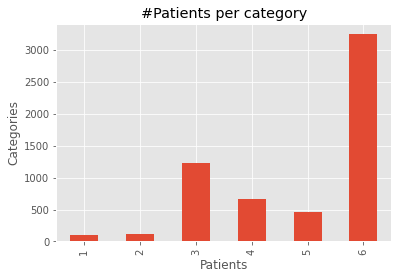

In [3]:
# number of patients per category
df_sub["Classificazione pazienti"].value_counts().sort_index().plot(kind='bar')
plt.title("#Patients per category")
plt.xlabel("Patients")
plt.ylabel("Categories")

In [4]:
# correct with the new data
diff = list(set(df_sub.index) - set(df.index))
df_sub_clean = df_sub.drop(diff)
df = df.sort_index(ascending=True)
# sum(df_sub_clean["Previous \nMyocardial Infarction - PMI"] == df["Previous \nMyocardial Infarction"])

df["Previous \nMyocardial Infarction"] = df_sub_clean["Previous \nMyocardial Infarction - PMI"]
df["Angiography"] = df_sub_clean["Angiography"]
df["Documented resting \nor exertional ischemia"] = df_sub_clean["Documented resting \nor exertional ischemia"]
df["Post-ischemic Dilated\nCardiomyopathy"] = df_sub_clean["Post-ischemic Dilated\nCardiomyopathy"]
df["Primary Dilated\nCardiomyopathy"] = df_sub_clean["Primary Dilated\nCardiomyopathy"]

In [5]:
# feature engineering
df_feat = df.copy()
df_feat["MIO"] = df_feat["MIN"] | df_feat["MIO"]
df_feat.rename(columns={"MIO": "MIO/MIN"}, inplace=True)
df_feat = df_feat.drop(columns=["MIN", "Angiography"])
# df_feat.info()

# fix all the NA patients
# 1. remove Suriveve7Y = 1 and NA
# 2. fill other NA's HR = average(HR of Survive7Y = 0) = 76
df_na = df_feat[df_feat.isna().any(axis=1)]
df_feat = df_feat.drop(df_na[df_na["Survive7Y"] == 1].index)
df_feat.loc[df_na[df_na["Survive7Y"] == 0].index, "HR"] = 76

years = 7
print("Total patient: \t", len(df_feat))
print("Survived: \t", df_feat[f"Survive{years}Y"].sum(), "\t", df_feat[f"Survive{years}Y"].sum()/len(df_feat))
print("Dead: \t\t", len(df_feat)-df_feat[f"Survive{years}Y"].sum(), "\t", (len(df_feat)-df_feat[f"Survive{years}Y"].sum())/len(df_feat))
# df_feat.info()

# df_feat.to_csv("data/data/data_cvd_clean_subset.csv")

Total patient: 	 4734
Survived: 	 4378 	 0.9247993240388678
Dead: 		 356 	 0.07520067596113224


In [6]:
# dataset train, valid, test split
def split_and_save(df, path, verbose=True):
    from sklearn.model_selection import train_test_split
    df.to_csv(f"{path}df.csv")
    df_train, df_test = train_test_split(df, test_size=0.165, stratify=df.iloc[:,-1])
    df_train, df_valid = train_test_split(df_train, test_size=0.2, stratify=df_train.iloc[:,-1])

    df_train.to_csv(f"{path}train.csv")
    df_valid.to_csv(f"{path}valid.csv")
    df_test.to_csv(f"{path}test.csv")

    if verbose: 
        print("Total: \t", len(df))
        print("Train: \t", len(df_train))
        print("Valid: \t", len(df_valid))
        print("Test: \t", len(df_test))
        print(f"Saved the dataset in {path} \n")

## Number of patients for each subgroup
- 6 Coronary Artery Disease
- 5 Cardiomiopatia Dilatative Primitiva
- 4 Miocardite, Pericardite, Endocardite... 
- 3 Ipertensione, Aritmie

In [7]:
diff = list(set(df_sub_clean.index) - set(df_feat.index))
df_sub_clean_na = df_sub_clean.drop(diff)
assert all(df_sub_clean_na.index == df_feat.index)

In [8]:
# divide into subgroups and save the datasets
df_6 = df_feat[df_sub_clean["Classificazione pazienti"] == 6]
df_5 = df_feat[df_sub_clean["Classificazione pazienti"] == 5]
df_4 = df_feat[df_sub_clean["Classificazione pazienti"] == 4]
df_3 = df_feat[df_sub_clean["Classificazione pazienti"] == 3]

# split_and_save(df_6, "data/data/7y_subset/6CAD/")
# split_and_save(df_5, "data/data/7y_subset/5CDP/")
# split_and_save(df_4, "data/data/7y_subset/4Cardite_Altro/")
# split_and_save(df_3, "data/data/7y_subset/3Ipertensione_Aritmie/")

# # save the whole dataset
split_and_save(df_feat, "data/data/7y_subset/complete/")

<ipython-input-8-5562322e4a46>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_6 = df_feat[df_sub_clean["Classificazione pazienti"] == 6]
<ipython-input-8-5562322e4a46>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_5 = df_feat[df_sub_clean["Classificazione pazienti"] == 5]
<ipython-input-8-5562322e4a46>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_4 = df_feat[df_sub_clean["Classificazione pazienti"] == 4]
<ipython-input-8-5562322e4a46>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_3 = df_feat[df_sub_clean["Classificazione pazienti"] == 3]


Total: 	 4734
Train: 	 3161
Valid: 	 791
Test: 	 782
Saved the dataset in data/data/7y_subset/complete/ 



In [11]:
from collections import Counter
print(Counter(df_6["Survive7Y"]))
print(Counter(df_5["Survive7Y"]))
print(Counter(df_4["Survive7Y"]))
print(Counter(df_3["Survive7Y"]))

Counter({1: 2406, 0: 213})
Counter({1: 318, 0: 41})
Counter({1: 460, 0: 66})
Counter({1: 1009, 0: 35})


In [25]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(35,30))
sns.heatmap(df_feat.corr(), annot=True)
# fig.savefig("feat.pdf")